In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
%matplotlib inline
from decimal import *
getcontext().prec = 6
import seaborn as sns

matplotlib.rcParams.update({'font.size': 5, 'lines.linewidth': 0.5, 'figure.dpi': 300})


In [2]:
import sys
sys.path.insert(1, './backtesting.py')

from backtesting import Backtest, Strategy
from backtesting.lib import crossover


/Users/johnsmith/quant/pk-crypto-tools/./backtesting.py/backtesting/_plotting.py:47: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [3]:
df = pd.read_json(r'./freq-user-data/data/binance/BTC_USDT-5m.json').dropna()
df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']

df['date'] = pd.to_datetime(df['timestamp'], unit='ms', utc=False)
# df.index = df['time']
# df.set_index('time', drop=True, inplace=True)
df.set_index(pd.DatetimeIndex(df["date"]), inplace=True, drop=True)
# df = df[['time', 'symbol', 'source', 'resolution', 'open', 'high', 'low', 'close', 'volume']]
# df.to_csv (r'./data/binance/BTC_USDT-5m.csv', index = None)
# df.set_index('time')
df = df.sort_index()

In [4]:
# ddf.iloc[-100:]

In [5]:
# pd.Timestamp('now').floor('D') + pd.Timedelta(-7, unit='D')

# start_time = datetime(2021,5,1)

start_time = pd.Timestamp('now') + pd.Timedelta(-20, unit='W')
# start_time
ddf = df.loc[df.index >= start_time].copy()
# ddf = df.loc[df['time'] >= start_time]
# ddf

# ddf = ddf.resample('5Min').agg(
#     OrderedDict([
#         ('open', 'first'),
#         ('high', 'max'),
#         ('low', 'min'),
#         ('close', 'last'),
#         ('volume', 'sum'),
#     ])
# ).dropna()

# ema = ddf.close.ewm(span=50,min_periods=0,adjust=False,ignore_na=False).mean()
# detrended = ddf.close - ddf.ema

ddf['lret'] = ddf.close.apply(np.log).diff(1).fillna(0)
ddf['cumlret'] = ddf.lret.cumsum()



In [40]:
len(wdgts)

12

In [1]:
hyperpar_tpl = '''
bla blabla
'''
tpl

'\nbla blabla\n'

In [79]:
{k: v['wdg'].value for k, v in strategy_params.items()}

{'w2log': 9,
 'w': 1,
 'bbma': 50,
 'bbstn': 50,
 'bbstd': 3.0,
 'adxn': 50,
 'adxdiff': 50.0,
 'adxtr': 20.0,
 'adxmp': 25.0,
 'adxmn': 0.0,
 'sl': -0.02,
 'tp': 0.02}

In [66]:

', '.join(strategy_params.keys())

'w2log, w, bbma, bbstn, bbstd, adxn, adxdiff, adxtr, adxmp, adxmn, sl, tp'

In [9]:
fee:float = 0.001
capital = 10000
risk_per_trade = 0.01
dlen = len(ddf)

sl_n2= IntSlider(description="n2", min=0, max=ceil(log(dlen, 2.0)+1), step=1, value=9)
sl_w = IntSlider(description="w", min=0, max=ceil(dlen/pow(2,sl_n2.value-1)-1), step=1, value=1)
def update_sl_w_range(*args):
    # wsize = pow(2,sl_n2.value)
    sl_w.max = ceil(dlen/pow(2,sl_n2.value-1)-1)
sl_n2.observe(update_sl_w_range, 'value')

# ', '.join(strategy_params.keys())
strategy_params = {
    'bbma': {'type': 'int', 'value': 50, 'step': 3},
    'bbstn': {'type': 'int', 'value': 50, 'step': 3},
    'bbstd': {'type': 'float', 'value': 3, 'step': 0.1},
    'adxn': {'type': 'int', 'value': 50, 'step': 2},
    'adxdiff': {'type': 'float', 'value': 50, 'step': 1},
    'adxtr': {'type': 'float', 'value': 20, 'step': 0.5},
    'adxmp': {'type': 'float', 'value': 25, 'step': 0.5},
    'adxmn': {'type': 'float', 'value': 0, 'step': 0.5},
    'sl': {'type': 'float', 'value': -0.02, 'step': 0.001},
    'tp': {'type': 'float', 'value': 0.02, 'step': 0.001},
}
for pk, pv in strategy_params.items():
    pv['wdg'] = globals()[(pv['wdg'] if 'wdg' in pv else pv['type'].capitalize() + 'Text')](
        description=pk,disabled=False,continuous_update=False,
        value=pv['value'], step=pv['step']
    )
strategy_params = {"w2log": {'wdg': sl_n2}, "w": {'wdg': sl_w}, **strategy_params}
wdgts = [pv['wdg'] for pk, pv in strategy_params.items()]

ui = widgets.VBox([widgets.HBox(wdgts[i:i+5]) for i in range(0, len(wdgts), 5)])

wst = wed = wsz = buy_sig = g_buy_sig_cum = buy_cond = False
sell_cond = sell_sig = buy_sig_ind = sell_sig_ind = False
wdf = wadf = False
position_groups = positions_start_row = positions_end_row =  positions_min_posret =  positions_max_posret = False
def printer(w2log, w, bbma, bbstn, bbstd, adxn, adxdiff, adxtr, adxmp, adxmn, sl, tp):
    global wst, wed, wsz, wdf, wadf
    with open(f'strat-params-bbands-convol.json', "w") as f: f.write(json.dumps({k: v['wdg'].value for k, v in strategy_params.items()}))

    wsz = floor(pow(2,w2log))
    wst = floor(w * wsz / 2)
    wed = floor(wst + wsz)
    
    wdf = ddf.iloc[wst:wed,:].copy()    
    wlen = len(wdf)

    wdf['bb_middle'] = wdf.close.ewm(span=bbma,min_periods=0,adjust=False,ignore_na=False).mean()
    wdf['bb_std'] = wdf.close.rolling(bbstn).std()
    wdf['bb_std_bw'] = wdf.bb_std * bbstd
    wdf['bb_lower'] = wdf['bb_middle'] + wdf.bb_std_bw
    wdf['bb_upper'] = wdf['bb_middle'] - wdf.bb_std_bw
    wdf["bb_percent"] = (
        (wdf["close"] - wdf["bb_lower"]) /
        (wdf["bb_upper"] - wdf["bb_lower"])
    )
    wdf["bb_width"] = (
        (wdf["bb_upper"] - wdf["bb_lower"]) / wdf["bb_middle"]
    )

    wadf = ta.adx(wdf.high, wdf.low, wdf.close, length=adxn, lensig=None, mamode=None, scalar=None, drift=None, offset=None)
    wadf.columns = ['adx','dmp','dmn']
    wadf['dm_diff'] = wadf['dmp'].values - wadf['dmn'].values

    wdf = wdf.join(wadf)

    buy_cond = (
        (wdf.open <= wdf.bb_lower) &
        (wdf.adx >= adxtr) & 
        (wdf.dm_diff > adxdiff) & 
        (wdf.dmp >= adxmp) & 
        (wdf.dmn <= adxmn)
    )

    buy_cond_vals = buy_cond.shift(fill_value=False).values
    open_price_arr = wdf.open.values
    high_price_arr = wdf.high.values
    low_price_arr = wdf.low.values

    enter_sig_arr = np.full(wlen, False)
    exit_sig_arr = np.full(wlen, False)
    in_pos_arr = np.full(wlen, 0)
    roi_ret_arr = np.full(wlen, 0.)

    in_pos = False
    enter_price = 0.
    stop_price = 0
    roi_price = 0.
    for i in range(max(bbma, bbstn), wlen):
        in_pos_arr[i] = in_pos
        if in_pos:
            exit_price: float = 0
            if low_price_arr[i] <= stop_price:
                exit_price = stop_price
            elif open_price_arr[i] - roi_price > 0:            
                exit_price = roi_price 
            
            if exit_price != 0:
                exit_sig_arr[i] = True
                ret = exit_price - enter_price 
                roi_ret_arr[i] = ret / enter_price - 2 * fee
                in_pos = False

        else:
            if buy_cond_vals[i]:
                in_pos = True
                enter_price = open_price_arr[i]
                # size = capital * risk_per_trade
                # pos = size/enter_price
                enter_sig_arr[i] = True
                stop_price = open_price_arr[i] * (1 + sl)
                roi_price = open_price_arr[i] * (1 + tp)
                # print("enter: {}, {}, {}".format(enter_price, stop_price, roi_price))
                in_pos_arr[i] = in_pos
            

    wdf['enter_sig'] = enter_sig_arr
    wdf['exit_sig'] = exit_sig_arr
    wdf['roi_ret'] = roi_ret_arr
    wdf['roi_cum_ret'] = wdf['roi_ret'].cumsum()
    wdf['in_pos'] = in_pos_arr

    wdf['poslret'] = wdf.lret * wdf.in_pos.astype(int)
    wdf.loc[wdf.enter_sig, 'poslret'] = 0
    wdf.loc[wdf.enter_sig.shift(fill_value=False), 'poslret'] -= fee
    wdf.loc[wdf.exit_sig, 'poslret'] -= fee

    wdf['g_enter'] = wdf.enter_sig.cumsum()
    wdf['g_exit'] = wdf.enter_sig.cumsum()

    enter_sig_ind = wdf[wdf.enter_sig].index
    exit_sig_ind = wdf[wdf.exit_sig].index
    
    enter_groups = wdf.groupby(wdf.g_enter, sort=False)
    exit_groups = wdf.groupby(wdf.g_enter, sort=False)
    wdf['poscumlret'] = enter_groups.poslret.cumsum() * wdf.in_pos.astype(int)
    wdf['totcumlret'] = wdf.poslret.cumsum()


    # positions_start_row = enter_groups.head(1)
    # positions_end_row = exit_groups.head(1)
    # positions_min_poscumlret = exit_groups.poscumlret.min()
    # positions_max_poscumlret = exit_groups.poscumlret.max()

    # wdf['poscumplret'] = wdf.totcumlret * wdf.in_pos.astype(int)

    wexits = wdf.loc[exit_sig_ind]
    wprofits = wexits[wexits.roi_ret > 0]
    wlosses = wexits[wexits.roi_ret <= 0]

    
#     with open(f'./strategy-results/{datetime.now():strat_%Y-%m-%d}.log', "a") as f: 
#         f.write(json.dumps(dict({   
#             "dt": f'{datetime.now():%Y-%m-%d %HH:%MM:%SS}',
#             "period_start": f'{ddf.index[0]}',
#             "period_end": f'{ddf.index[-1]}',
#             "params": dict({ 'sl': sl, 'ts': ts, 'tp': tp, 'ma1n': ma1n, 'ma2n': ma2n, 'ma1c': ma1c, 'ma2c': ma2c, 'trn': trn, 'mrn': mrn, 'xrr': xrr
# #                         'std': std, 'stk': stk, 'stsm': stsm, 'stt': slStT.value
#                            }),
#             "strategy": "2EMASTH",
#             "profit": floor(100* (trades.iloc[-1].cap / capital - 1)) if len(trades.index) else 0. 
#         })
#     )); f.write("\n");
    
    
    plt.close("all")
    fig = plt.figure(constrained_layout=True,figsize=(16,5))
    gs0 = fig.add_gridspec(1, 2, width_ratios=[3,1])

    gs00 = gs0[0,0].subgridspec(4, 1, height_ratios=[2,2,1,1])
    gs01 = gs0[0,1].subgridspec(4, 1)

    ax001 = fig.add_subplot(gs00[0,0])
    ax002 = fig.add_subplot(gs00[1,0], sharex=ax001)
    ax003 = fig.add_subplot(gs00[2,0], sharex=ax001)
    ax004 = fig.add_subplot(gs00[3,0], sharex=ax001)

    ax101 = fig.add_subplot(gs01[0,0])
    ax102 = fig.add_subplot(gs01[1,0])
    ax103 = fig.add_subplot(gs01[2,0])
    ax104 = fig.add_subplot(gs01[3,0])

    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax001.xaxis.set_major_locator(locator)
    ax001.xaxis.set_major_formatter(formatter)

    wclose_min = wdf.close.min()
    wclose_max = wdf.close.max()

    ax001.plot(wdf['close'])
    ax001.plot(wdf['low'], lw=0.5)
    ax001.plot(wdf['high'], lw=0.5)
    ax001.plot(wdf.bb_middle)
    ax001.plot(wdf.bb_lower)
    ax001.plot(wdf.bb_upper)
    if len(enter_sig_ind): ax001.vlines(enter_sig_ind, wclose_min, wclose_max, lw=1, color="b")
    if len(wprofits) > 0: ax001.vlines(wprofits.index, wclose_min , wclose_max, lw=1, color="g", linestyle='--')
    if len(wlosses) > 0: ax001.vlines(wlosses.index, wclose_min , wclose_max, lw=1, color="r", linestyle='--')
    
    ax001.fill_between(wdf.index, wdf.bb_middle*0.99, wdf.bb_middle*1.01, alpha=0.15)

    min_poscumlret = wdf.poscumlret.min()
    max_poscumlret = wdf.poscumlret.max()
    ax002.plot(wdf.poscumlret)
    # ax002.plot(wdf.postradecumlret, linestyle='dotted')
    ax002.axhline()
    ax002.axhline(y=sl, color='b', linestyle='dotted')
    ax002.axhline(y=tp, color='b', linestyle='dotted')
    ax002.vlines(enter_sig_ind, min_poscumlret, max_poscumlret, lw=0.5, color="b")
    if len(wprofits) > 0: ax002.vlines(wprofits.index, min_poscumlret , max_poscumlret, lw=0.5, color="g", linestyle='--')
    if len(wlosses) > 0: ax002.vlines(wlosses.index, min_poscumlret , max_poscumlret, lw=0.5, color="r", linestyle='--')
    # ax002.hlines(positions_min_poscumlret,positions_start_row.index, positions_end_row.index, color='r', linestyle='--')
    # ax002.hlines(positions_max_poscumlret,positions_start_row.index, positions_end_row.index, color='g', linestyle='--')

    # min_totcumlret = wdf.totcumlret.min()
    # max_totcumlret = wdf.totcumlret.max()
    # ax003.plot(wdf.totcumlret, color='b', lw=0.5)
    # ax003.axhline()
    # ax003.axhline(y=stoploss, color='b', linestyle='dotted')
    # ax003.axhline(y=takeprofit, color='b', linestyle='dotted')
    # ax003.vlines(enter_sig_ind, min_totcumlret, max_totcumlret, lw=0.5, color="b")
    # if len(wprofits) > 0: ax003.vlines(wprofits.index, min_totcumlret , max_totcumlret, lw=0.5, color="g", linestyle='--')
    # if len(wlosses) > 0: ax003.vlines(wlosses.index, min_totcumlret , max_totcumlret, lw=0.5, color="r", linestyle='--')

    min_adx = min(wdf.adx.min(),wdf.dmp.min(),wdf.dmn.min(),wdf.dm_diff.min())
    max_adx = max(wdf.adx.max(),wdf.dmp.max(),wdf.dmn.max(),wdf.dm_diff.max())
    ax003.plot(wdf.adx)
    ax003.plot(wdf.dmp, color='g')
    ax003.plot(wdf.dmn, color='r')
    ax003.plot(wdf.dm_diff, color='black', linestyle='dotted')
    ax003.axhline(y=20)
    ax003.vlines(enter_sig_ind, min_adx, max_adx, lw=0.5, color="b")
    if len(wprofits) > 0: ax003.vlines(wprofits.index, min_adx, max_adx, lw=0.5, color="g", linestyle='--')
    if len(wlosses) > 0: ax003.vlines(wlosses.index, min_adx, max_adx, lw=0.5, color="r", linestyle='--')
    
    # min_roi_cum_ret_perc = wdf.roi_cum_ret_perc.min()
    # max_roi_cum_ret_perc = wdf.roi_cum_ret_perc.max()
    ax004.plot(wdf.roi_cum_ret)
    ax004.axhline()
    # ax004.axhline(y=50)
    # ax004.axhline(y=20, linestyle='dotted')
    # ax004.axhline(y=80, linestyle='dotted')
    # ax004.vlines(buy_sig_ind, min_roi_cum_ret_perc, max_roi_cum_ret_perc, lw=0.5, color="b")
    # if len(wprofits) > 0: ax004.vlines(wprofits.index, min_roi_cum_ret_perc , max_roi_cum_ret_perc, lw=0.5, color="g", linestyle='--')
    # if len(wlosses) > 0: ax004.vlines(wlosses.index, min_roi_cum_ret_perc , max_roi_cum_ret_perc, lw=0.5, color="r", linestyle='--')

    # conv1_min = wdf.conv1.min()
    # conv1_max = wdf.conv1.max()
    # ax002.plot(wdf.conv1)
    # ax002.axhline(color='b', linestyle='--')
    # ax002.vlines(buy_sig_ind, conv1_min, conv1_max, lw=0.5, color="b")
    # if len(wprofits) > 0: ax002.vlines(wprofits.index, conv1_min , conv1_max, lw=0.5, color="g", linestyle='--')
    # if len(wlosses) > 0: ax002.vlines(wlosses.index, conv1_min , conv1_max, lw=0.5, color="r", linestyle='--')

    # ax101.plot(krx, kry)
    # ax101.axhline(color='b', linestyle='--')

    # ax102.plot(tret)
    # ax102.axhline(color='b', linestyle='--')
    
    plt.show()
    # print(pf.stats())
    # print(pf.returns_stats())
    


with open('strat-params-bbands-convol.json') as f: 
    js = json.loads(f.read());
    for k, v in strategy_params.items(): 
        if k in js: v['wdg'].value=js[k];
                                        

out = widgets.interactive_output(printer, {k : v['wdg'] for k,v in strategy_params.items()})
display(ui, out)



Output()

In [50]:
import pyperclip
# pyperclip.copy('The text to be copied to the clipboard.')
# spam = pyperclip.paste()
timerange = "{}-{}".format(floor(wdf.iloc[0].timestamp/1000), floor(wdf.iloc[-1].timestamp/1000))
cmds = ['freqtrade backtesting -c freqtrade-config.json --userdir freq-user-data --strategy BBandsStrategy --timeframe 1m --timerange {}'.format(timerange) , 
'freqtrade plot-dataframe  -c freqtrade-config.json -s BBandsStrategy --timerange {}'.format(timerange), 
'freqtrade plot-profit  -c freqtrade-config.json -s BBandsStrategy --timerange {}'.format(timerange)]
pyperclip.copy("\n".join(cmds))

In [51]:
wdf[wdf.enter_sig]

,timestamp,open,high,low,close,volume,date,lret,cumlret,bb_middle,...,enter_sig,exit_sig,roi_ret,roi_cum_ret,in_pos,poslret,g_enter,g_exit,poscumlret,totcumlret
date,,,,,,,,,,,,,,,,,,,,,
2021-07-23 06:15:00,1627020900000,32526.27,32583.05,32500.0,32569.43,82.880615,2021-07-23 06:15:00,0.001313,0.927419,32635.229135,...,True,False,0.0,0.000,1,0.0,1,1,0.0,0.000000
2021-07-24 08:15:00,1627114500000,33620.00,33717.93,33620.0,33684.88,205.042889,2021-07-24 08:15:00,0.001928,0.961094,33758.514930,...,True,False,0.0,0.018,1,0.0,2,2,0.0,0.015242


In [17]:
fparams = 'strat-params-bbands-stats.json'
dlen = len(ddf)

sl_n2= IntSlider(description="n2", min=0, max=ceil(log(dlen, 2.0)+1), step=1, value=9)
sl_w = IntSlider(description="w", min=0, max=ceil(dlen/pow(2,sl_n2.value-1)-1), step=1, value=1)
def update_sl_w_range(*args):
    sl_w.max = ceil(dlen/pow(2,sl_n2.value-1)-1)
sl_n2.observe(update_sl_w_range, 'value')

wdg_wdelta = widgets.FloatText(value=-2.5,step=0.25,description='wdelta:',disabled=False,continuous_update=False)


wdg_bbma = widgets.IntText(value=50,step=3,description='bbma:',disabled=False,continuous_update=False)
wdg_bbstn = widgets.IntText(value=50,step=3,description='bbstn:',disabled=False,continuous_update=False)
wdg_bbstd = widgets.FloatText(value=3,step=0.1,description='bbstd:',disabled=False,continuous_update=False)
wdg_bbwidth = widgets.FloatText(value=3,step=0.1,description='bbwidth:',disabled=False,continuous_update=False)
wdg_bbpercent = widgets.FloatText(value=3,step=0.1,description='bbperc:',disabled=False,continuous_update=False)

wdg_adxn = widgets.IntText(value=50, step=2, description='adxn:',disabled=False,continuous_update=False)
wdg_adxdiff = widgets.IntText(value=50, step=2, description='adxdiff:',disabled=False,continuous_update=False)
wdg_adxtr = widgets.IntText(value=25,step=2,description='adxt:',disabled=False,continuous_update=False)
wdg_adxmp = widgets.IntText(value=10, step=2, description='adxmp:',disabled=False,continuous_update=False)
wdg_adxmn = widgets.IntText(value=0, step=2, description='adxmn:',disabled=False,continuous_update=False)

ui = widgets.VBox([
    widgets.HBox([sl_n2, sl_w, wdg_wdelta]),
    widgets.HBox([wdg_bbma, wdg_bbstn, wdg_bbstd, wdg_bbwidth, wdg_bbpercent]),
    widgets.HBox([wdg_adxn, wdg_adxtr, wdg_adxdiff, wdg_adxmn, wdg_adxmp])
])

axs = False
fcumret = posgroups = False
wdf = wdf = posdf = pgheads = phf = False
skipn = False
def stats_printer(w2log, w, wdelta, bbma, bbstn, bbstd, bbpercent, bbwidth, adxn, adxtr, adxdiff, adxmp, adxmn):

    global wst, wed, wsz, wdf, wadf, axs, fcumret, posdf, posgroups, phf, skipn
    skipn = max(bbma, bbstd, adxn)
    pars = {k: v.value for k, v in dvals.items()}
    with open(fparams, "w") as f: f.write(json.dumps(pars)) 

    wsz = floor(pow(2,w2log))
    wst = floor(w * wsz / 2)
    wed = floor(wst + wsz)
    
    wdf = ddf.iloc[wst:wed,:].copy()    
    wlen = len(wdf)


    wdf['lret'] = ddf.close.apply(np.log).diff(1).fillna(0)

    wdf['bb_middle'] = wdf.close.ewm(span=bbma,min_periods=0,adjust=False,ignore_na=False).mean()
    wdf['bb_std'] = wdf.close.rolling(bbstn).std()
    wdf['bb_std_bw'] = wdf.bb_std * bbstd
    wdf['bb_lower'] = wdf['bb_middle'] - wdf.bb_std_bw
    wdf['bb_upper'] = wdf['bb_middle'] + wdf.bb_std_bw

    wdf["bb_percent"] = (wdf["close"] - wdf["bb_lower"]) / (wdf["bb_upper"] - wdf["bb_lower"]) * 100
    wdf["bb_width"] = (wdf["bb_upper"] - wdf["bb_lower"]) / wdf["bb_middle"] * 100
    wdf['bb_overval'] = (wdf.close - wdf.bb_middle) / wdf.bb_middle

    wadf = ta.adx(wdf.high, wdf.low, wdf.close, length=adxn, lensig=None, mamode=None, scalar=None, drift=None, offset=None)
    wadf.columns = ['adx','dmp','dmn']

    wadf['dm_diff'] = wadf['dmp'].values - wadf['dmn'].values

    wdf = wdf.join(wadf)
    # wdf = wdf.iloc[skipn:].copy()

    wdf_freq = pd.Timedelta(5, unit='m')
    pdelta = pd.Timedelta(wdelta, unit="h")
    pdelta_ticks = floor(pdelta / wdf_freq)

    wdf['fucumret'] = wdf.lret.rolling(pdelta).sum().shift(-pdelta_ticks)


    buy_cond = (
        (wdf.open <= wdf.bb_lower) &
        (wadf.adx >= adxtr) & 
        (wadf.dm_diff > adxdiff) & 
        (wadf.dmp >= adxmp) & 
        (wadf.dmn <= adxmn) #& 
        # (wdf.bb_width >= bbwidth) & 
        # (wdf.bb_percent >= bbpercent)
    )

    buy_sig = buy_cond & (~buy_cond).shift(fill_value=False)
    # buy_sig = buy_sig.shift(fill_value=False)

    wdf['g_buy'] = buy_sig.cumsum()
    posgroups = wdf.groupby(wdf.g_buy)

    phf = posgroups.head(1)
    wdf.loc[phf.index, 'lret'] = 0

    wdf['poscumret'] = posgroups.lret.cumsum()
    wdf.loc[phf.index, 'ptret'] = posgroups.poscumret.tail(1).values
    wdf.loc[phf.index, 'minret'] = posgroups.poscumret.min().values
    wdf.loc[phf.index, 'maxret'] = posgroups.poscumret.max().values
    phf = posgroups.head(1)


    # wdf[~buy_cond].fucumret = 0
    bwdf = wdf[buy_sig]
    bwadf = wadf[buy_sig]
    
    plt.close("all")
    s=0.1
    fig, axs = plt.subplots(3, 4, constrained_layout=True, figsize=(12,5))
    axsf = axs.flat
    for axi in range(1, len(axsf)):
        ax = axsf[axi]
        ax.axhline(color='b')

    # axs[0,0].format_xdata = mdates.DateFormatter('%m-%d')
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    axs[0,0].xaxis.set_major_locator(locator)
    axs[0,0].xaxis.set_major_formatter(formatter)

    axs[0,0].set_title('price')
    axs[0,0].plot(wdf.close)
    axs[0,0].plot(wdf.bb_middle)
    axs[0,0].plot(wdf.bb_lower)

    # sns.displot(wdf.fucumret, ax=axs[0,1])
    # sns.displot(wdf, x='fucumret', hue='overval', ax=axs[0,2])

    axs[0,1].set_title('adx/ret')
    # axs[0,1].scatter(phf.adx.values, phf.fucumret.values, s=s)
    axs[0,1].scatter(phf.adx.values, phf.minret.values, s=s, color='r')
    axs[0,1].scatter(phf.adx.values, phf.maxret.values, s=s, color='g')

    axs[0,2].set_title('dmp/ret')
    # axs[0,2].scatter(phf.dmp.values, phf.fucumret.values, s=s)
    axs[0,2].scatter(phf.dmp.values, phf.minret.values, s=s, color='r')
    axs[0,2].scatter(phf.dmp.values, phf.maxret.values, s=s, color='g')
    
    axs[0,3].set_title('dmn/ret')
    # axs[0,3].scatter(phf.dmn.values, phf.fucumret.values, s=s)
    axs[0,3].scatter(phf.dmn.values, phf.minret.values, s=s, color='r')
    axs[0,3].scatter(phf.dmn.values, phf.maxret.values, s=s, color='g')


    # axs[1,0].set_title('dm_diff/ret')
    # # axs[1,0].scatter(bwadf.dm_diff.values, phf.fucumret.values, s=0.1)
    # axs[1,0].scatter(phf.dm_diff.values, phf.minret.values, s=0.05, color='r')
    # axs[1,0].scatter(phf.dm_diff.values, phf.maxret.values, s=0.05, color='g')

    axs[1,1].set_title('bb_overval/ret')
    # axs[1,1].scatter(phf.overval.values, phf.fucumret.values, s=s)
    axs[1,1].scatter(phf.bb_overval.values, phf.minret.values, s=s, color='r')
    axs[1,1].scatter(phf.bb_overval.values, phf.maxret.values, s=s, color='g')

    # axs[1,2].set_title('bb_percent/ret')
    # # axs[1,2].scatter(phf.bb_percent.values, phf.fucumret.values, s=s)
    # axs[1,2].scatter(phf.bb_percent.values, phf.minret.values, s=s, color='r')
    # axs[1,2].scatter(phf.bb_percent.values, phf.maxret.values, s=s, color='g')

    # axs[1,3].set_title('bb_width/ret')
    # # axs[1,3].scatter(phf.bb_width.values, phf.fucumret.values, s=s)
    # axs[1,3].scatter(phf.bb_width.values, phf.minret.values, s=s, color='r')
    # axs[1,3].scatter(phf.bb_width.values, phf.maxret.values, s=s, color='g')


    axs[2,1].set_title('dm_diff/ret')
    # axs[2,1].scatter(phf.dm_diff.values, phf.fucumret.values, s=s)
    axs[2,1].scatter(phf.dm_diff.values, phf.minret.values, s=s, color='r')
    axs[2,1].scatter(phf.dm_diff.values, phf.maxret.values, s=s, color='g')

    # axs[2,0].set_title('minret/maxret')
    # axs[2,0].scatter(-bwdf.minposcumret.values, bwdf.maxposcumret.values, s=0.1)

    # axs[1,2].scatter(wdf.bb_percent.values, fcumret.values, s=0.2)
    # axs[1,3].scatter(wdf.bb_width.values, fcumret.values, s=0.2)
    # for ax in axs.flat:
    #     ax.plot([1,2])
    
    plt.show()
    

dvals = {
    "w2log":sl_n2, "w":sl_w, 
    'bbma': wdg_bbma, 'bbstn': wdg_bbstn, 'bbstd': wdg_bbstd, 'bbpercent': wdg_bbpercent, 'bbwidth': wdg_bbwidth,
    'adxn': wdg_adxn, 'adxtr': wdg_adxtr, 'adxdiff': wdg_adxdiff, 'adxmp': wdg_adxmp, 'adxmn': wdg_adxmn, 
    'wdelta': wdg_wdelta,
    }
     

if os.path.isfile(fparams): 
    with open(fparams) as f: 
        js = json.loads(f.read());
        for k, v in dvals.items(): 
            if k in js: v.value=js[k] ;
                    
out = widgets.interactive_output(stats_printer, dvals)
display(ui, out)


Output()

In [344]:

wdf['poscumret'] = posgroups.lret.cumsum()
wdf.loc[pgheads.index, 'ptret'] = posgroups.poscumret.tail(1).values
wdf.loc[pgheads.index, 'minret'] = posgroups.poscumret.min().values
wdf.loc[pgheads.index, 'maxret'] = posgroups.poscumret.max().values
pgheads = posgroups.head(1)



In [9]:
wdf.iloc[100:,6:]

,date,lret,cumlret,bb_middle,bb_std,bb_std_bw,bb_lower,bb_upper,bb_percent,bb_width,...,dmp,dmn,dm_diff,fucumret,overval,g_buy,poscumret,ptret,minret,maxret
date,,,,,,,,,,,,,,,,,,,,,
2021-06-30 22:15:00,2021-06-30 22:15:00,0.000876,-0.370891,34779.007066,137.894968,124.105471,34654.901596,34903.112537,11.437209,0.713680,...,21.006526,21.880678,-0.874152,-0.010364,-0.694130,2,0.000876,NaN,NaN,NaN
2021-06-30 22:20:00,2021-06-30 22:20:00,0.003790,-0.367101,34781.327901,130.163849,117.147464,34664.180437,34898.475365,64.363136,0.673623,...,23.349877,20.710185,2.639691,-0.015720,0.258536,2,0.004666,NaN,NaN,NaN
2021-06-30 22:25:00,2021-06-30 22:25:00,-0.000464,-0.367565,34782.457714,122.331598,110.098438,34672.359276,34892.556152,57.439836,0.633069,...,23.699130,20.471767,3.227363,-0.016614,0.133917,2,0.004202,NaN,NaN,NaN
2021-06-30 22:30:00,2021-06-30 22:30:00,0.002473,-0.365092,34789.073990,122.460533,110.214480,34678.859511,34899.288470,93.522417,0.633615,...,26.172294,19.377435,6.794859,-0.017143,0.783403,2,0.006676,NaN,NaN,NaN
2021-06-30 22:35:00,2021-06-30 22:35:00,-0.000929,-0.366021,34793.172442,111.916430,100.724787,34692.447655,34893.897230,79.499967,0.578992,...,25.346750,18.766219,6.580531,-0.016623,0.530999,2,0.005746,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-14 01:25:00,2021-07-14 01:25:00,-0.000561,-0.440585,32498.024729,143.792499,129.413249,32368.611480,32627.437978,-7.820482,0.796438,...,14.236596,25.240265,-11.003669,NaN,-1.040769,277,0.002630,NaN,NaN,NaN
2021-07-14 01:30:00,2021-07-14 01:30:00,-0.000758,-0.441343,32486.788295,149.735142,134.761628,32352.026668,32621.549923,-10.450552,0.829640,...,13.643287,26.012700,-12.369412,NaN,-1.088110,277,0.001872,NaN,NaN,NaN
2021-07-14 01:35:00,2021-07-14 01:35:00,0.003178,-0.438165,32482.914857,149.951604,134.956444,32347.958413,32617.871301,29.191488,0.830938,...,17.642380,24.097720,-6.455339,NaN,-0.374553,277,0.005050,NaN,NaN,NaN


In [11]:
# sns.displot(wdf, x="fucumret", hue="bb_width", stat="density")
dlen

36655

In [372]:

24.99 / 96

0.2603125

In [868]:

wdg_krn = widgets.IntText(value=50,description='krn:',disabled=False)
wdg_krpow = widgets.FloatText(value=1, step=0.05,description='krpow:',disabled=False)
wdg_krstart = widgets.FloatText(value=0, step=1/6.,description='krstrt:',disabled=False)
wdg_krend = widgets.FloatText(value=2, step=1/6.,description='krend:',disabled=False)
wdg_krflip = widgets.Checkbox(value=False,description='krflip:',disabled=False)
wdg_krflipy = widgets.Checkbox(value=False,description='krflipy:',disabled=False)
ui = widgets.VBox([
        widgets.HBox([wdg_krn, wdg_krstart, wdg_krend, wdg_krpow]),
        widgets.HBox([wdg_krflip, wdg_krflipy])
    ])
kry = False
def inter_plot(krn, krstart, krend, krpow, krflip, krflipy):
    global kry

    with open(f'./strat-params-fn-convol.json', "w") as f: f.write(json.dumps({k: v.value for k, v in dvals.items()})) 
    plt.close("all")
    krx = np.linspace(krstart, krend, krn)
    kry = krx
   
    # kry = np.tan(kry)
    kry = np.sin(kry) #*pi
    kry = np.power(kry , krpow)
    kry = np.tan(kry)
    # kry = np.exp(kry)
    # kry = np.power(kry , krpow)
    # kry = np.arctan(kry)
    # kry = np.cos(kry)
    if krflip: kry = np.flipud(kry)
    if krflipy: kry = -(kry)
    kry = kry - np.mean(kry)
    
    
    fig, (ax1) = plt.subplots(1, 1,figsize=(2,0.5), sharex='col', gridspec_kw={'width_ratios': [1]})
    ax1.plot(krx, kry)
    # ax1.plot(krx, np.flipud(kry))

dvals = {'krn': wdg_krn, 'krstart': wdg_krstart, 'krend': wdg_krend, 'krpow': wdg_krpow,
    'krflip': wdg_krflip, 'krflipy': wdg_krflipy}


with open('./strat-params-fn-convol.json') as f: 
    js = json.loads(f.read());
    for k, v in dvals.items(): 
        if k in js: v.value=js[k] ;

out = widgets.interactive_output(inter_plot, dvals)
display(ui, out)


Output()

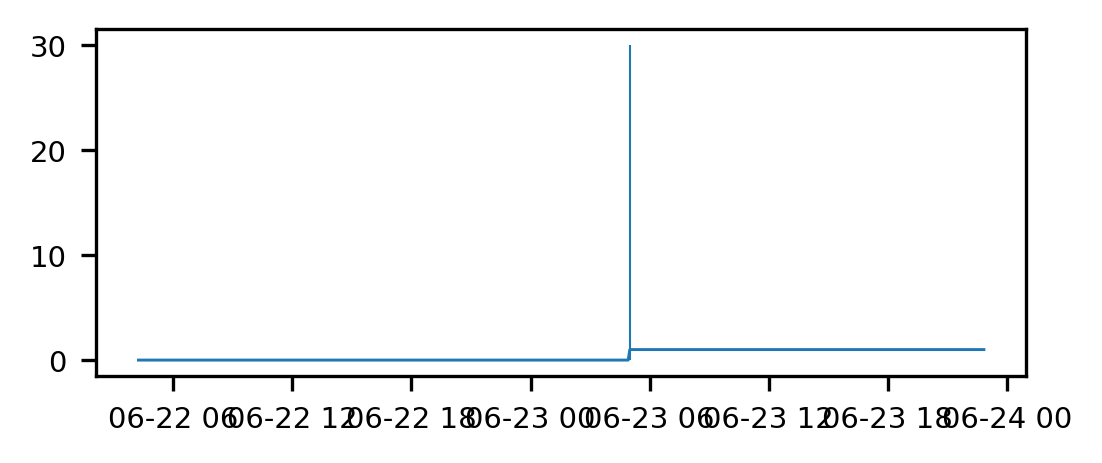

In [261]:
fig = plt.figure(figsize=(4,1.5),dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.plot(g_buy_sig_cum)
ax.vlines(wbsig.index, 0 , 30, lw=0.5)
# ax.plot(xdata2, ydata2, color='tab:orange')

